Проект в рамках курса DLS от МФТИ: kaggle.com/c/simpsons4

# Импорт библиотек

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision import datasets, models, transforms

import PIL
from PIL import Image

import math
import random
import seaborn as sn
import pandas as pd
import numpy as np
from pathlib import Path
from skimage import io
import pickle
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
print("Pillow Version: ", PIL.PILLOW_VERSION)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

PyTorch Version:  1.4.0
Torchvision Version:  0.5.0
Pillow Version:  5.4.1
CUDA is available!  Training on GPU ...


# Формирование пути к данным

In [2]:
# input/... путь к данным такой же как в ссылке опубликованного датасета kaggle.com/alexattia/the-simpsons-characters-dataset
train_dir = Path('/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/')
test_dir = Path('/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/')

### Разделим выборку на train, val и test

In [3]:
class SimpsonTrainValPath():

  def __init__(self, train_dir, test_dir):
    
    self.train_dir = train_dir
    self.test_dir = test_dir
    self.train_val_files_path = sorted(list(self.train_dir.rglob('*.jpg')))
    self.test_path = sorted(list(self.test_dir.rglob('*.jpg')))
    self.train_val_labels = [path.parent.name for path in self.train_val_files_path]

  def get_path(self):
      
    train_files_path, val_files_path = train_test_split(self.train_val_files_path, test_size = 0.3, \
                                          stratify=self.train_val_labels)
    
    files_path = {'train': train_files_path, 'val': val_files_path}
    
    return files_path, self.test_path
  
  def get_n_classes(self):
    return len(np.unique(self.train_val_labels))

In [4]:
SimpsonTrainValPath = SimpsonTrainValPath(train_dir, test_dir)
train_path, test_path = SimpsonTrainValPath.get_path()

# Модуль тренировки

In [5]:
def train_model(model, dataloaders, criterion, optimizer, save_best_weights_path, save_last_weights_path, best_acc, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []
    lr_find_lr = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Установим режим модели
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Режим тренировки
            else:
                model.eval()   # Режим оценки

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm_notebook(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # обновим значения градиента
                optimizer.zero_grad()

                # forward
                # сохраняем историю, если режим тренировки
                with torch.set_grad_enabled(phase == 'train'):
                    # расчитываем loss
                    # случай для модели inception
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimizer + scheduler если режим тренировки
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                        lr_step = optimizer_ft.state_dict()["param_groups"][0]["lr"]
                        lr_find_lr.append(lr_step)

                # статистика
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # loss, acc эпохи
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # сохраняем лучшую модель 
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            # сохраняем acc 
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
        
        print()
    # распечатаем время тренировки
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим модель с лучшими весами
    model.load_state_dict(best_model_wts)

    history_val = {'loss': val_loss_history, 'acc': val_acc_history}
    history_train = {'loss': train_loss_history, 'acc': train_acc_history}
    
    return model, history_val, history_train, time_elapsed, lr_find_lr, best_acc

# Отключение вычисления градиента

In [6]:
# feature_extracting = False - вычисляем градиент у всей сети
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Модели

In [7]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    
    model_ft = None
    input_size = 0
       
    if model_name == "resnet152":
        """ Resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        # отключает обновление градиентов у замороженных слоев
        set_parameter_requires_grad(model_ft, feature_extract)
        # получаем кол-во нейронов входящих в последний слой
        num_ftrs = model_ft.fc.in_features
        # на последний слой, устанавливаем необходимый выход
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif model_name == 'resnext-101-32x8d':
        """ ResNeXt-101-32x8d
        """
        model_ft = models.resnext101_32x8d(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet161(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Генерация данных

In [8]:
class SimpsonsDataset(Dataset):

    def __init__(self, files_path, data_transforms):
      self.files_path = files_path
      self.transform = data_transforms
      
      if 'test' not in str(self.files_path[0]):
        self.labels = [path.parent.name for path in self.files_path]
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.labels)
        
        with open('label_encoder.pkl', 'wb') as le_dump_file:
            pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
      return len(self.files_path)

    def __getitem__(self, idx):

      img_path = str(self.files_path[idx]) 
      image = Image.open(img_path)
      image = self.transform(image)
      
      if 'test' in str(self.files_path[0]):
        return image
      else: 
        label_str = str(self.files_path[idx].parent.name)
        label = self.label_encoder.transform([label_str]).item()
        
        return image, label

# Инициализация модели и подготовка данных

### Настройка модели

Создать в Google Drive папку с **таким же (model_name)** названием модели, для её сохранения.

In [9]:
# Выбираем модель из определенных в initialize_model
model_name = 'resnet152'
# Дополнительное описание для сохранения модели
fc_layer = 'all-st-SGD-m.9-nest-s-cycle-exp-.00001-.05-g.99994-m.8-.9'

# Количество классов в датасете
num_classes = SimpsonTrainValPath.get_n_classes()

# Размер батча
batch_size = 32

# Количество эпох
num_epochs = 2

# настройка device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# feature_extract = False - обучаем всю модель
# feature_extract = True - обучаем FC
feature_extract = False

# Сохранение весов модели
save_last_weights_path = '/kaggle/working/' + model_name + '-' + fc_layer + '_last_weights.pth'
save_best_weights_path = '/kaggle/working/' + model_name + '-' + fc_layer + '_best_weights.pth'

### Инициализация модели

In [10]:
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# отправим модель на GPU
model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


### Аугментация данных

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.RandomChoice( [ 
                                  transforms.RandomHorizontalFlip(p=0.5),
                                  transforms.ColorJitter(contrast=0.9),
                                  transforms.ColorJitter(brightness=0.1),
                                  transforms.RandomApply( [ transforms.RandomHorizontalFlip(p=1), transforms.ColorJitter(contrast=0.9) ], p=0.5),
                                  transforms.RandomApply( [ transforms.RandomHorizontalFlip(p=1), transforms.ColorJitter(brightness=0.1) ], p=0.5),
                                  ] ),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Данные для подачи в сеть

### Dataset

In [12]:
image_datasets = {mode: SimpsonsDataset(train_path[mode], data_transforms[mode]) for mode in ['train', 'val']}
image_datasets_test = SimpsonsDataset(test_path, data_transforms['val'])

### Dataloader

In [13]:
dataloaders_dict = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
                    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True, num_workers=4)}
dataloader_test = torch.utils.data.DataLoader(image_datasets_test, batch_size=batch_size, shuffle=False, num_workers=4)

### Визуализируем данные

In [14]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

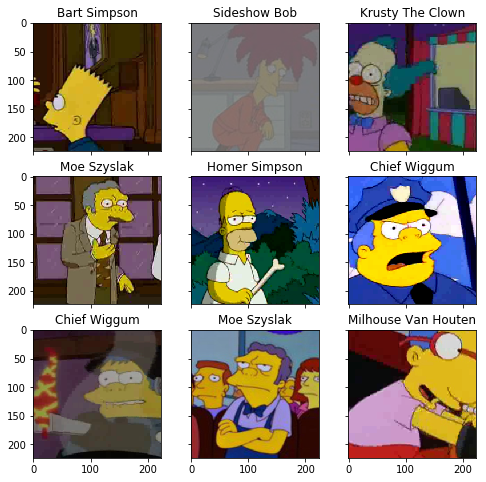

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 4500))
    im_val, label = image_datasets['train'][random_characters]
    # inverse_transform это метод LabelEncoder(), мы закодировали цифрами классы, с помощью inverse_transform из чисел вернём название класса
    # получаем имя персонажа с заглавных букв
    img_label = " ".join(map(lambda x: x.capitalize(),\
                image_datasets['val'].label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Визуализация обучения

In [16]:
def visualization(train, val, is_loss = True):
  
  if is_loss:
    plt.figure(figsize=(17,10))
    plt.plot(train, label = 'Training loss')
    plt.plot(val, label = 'Val loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
  
  else:
    plt.figure(figsize=(17,10))
    plt.plot(train, label = 'Training acc')
    plt.plot(val, label = 'Val acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()

### Параметры для оптимизации

In [17]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            #print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            pass
            #print("\t",name)

Params to learn:


# Тренировка

Тренировка состоит из двух этапов:
- Найти оптимальный диапазон для lr, чтобы изменять его циклически используя lr_scheduler.CyclicLR из библиотеки Pytorch
- Тренировать модель, используя найденный диапазон

#### Определение оптимального learning rate (lr)

Оптимизацию lr будем проводить используя циклическое изменение его значений в указанном диапазоне. Вначале необходимо определить оптимальные границы диапазона. Для этого проведем тестовый запуск. Выберем step size таким образом, чтобы во время тестового запуска lr линейно возрастал. <br>

После чего построим график accuracy относительно learning rate, на основании графика выберем диапазон значений.

Метод: https://arxiv.org/pdf/1506.01186.pdf

In [18]:
base_lr = 0.00001
max_lr = 0.05
lr_find_epochs = 2

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9, nesterov = True)

step_size = lr_find_epochs * len(dataloaders_dict['train'])

scheduler = optim.lr_scheduler.CyclicLR(optimizer_ft, base_lr = base_lr, max_lr = max_lr, step_size_up=step_size, mode='exp_range', gamma=0.99994, scale_mode='cycle', cycle_momentum=True, base_momentum=0.8, max_momentum=0.9, last_epoch=-1)

#### Функция для поиска оптимального диапазона lr

In [19]:
def search_lr(lr_find_epochs):
  
  accs = []
  lr_find_lr = []
  acc_sum = 0.0

  for i in range(lr_find_epochs):
    print("epoch {}".format(i))
    for inputs, labels in tqdm_notebook(dataloaders_dict['train']):
      
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      model_ft.train()
      optimizer_ft.zero_grad()
      
      outputs = model_ft(inputs)
      loss = criterion(outputs, labels)
      preds = torch.argmax(outputs, 1)
      acc_running = torch.sum(preds == labels.data).item()
      acc_sum += torch.sum(preds == labels.data).item()

      loss.backward()
      optimizer_ft.step()
      scheduler.step()
      
      lr_step = optimizer_ft.state_dict()["param_groups"][0]["lr"]
      lr_find_lr.append(lr_step)
      
      accs.append(acc_running)
  accs = np.array(accs) / acc_sum
  
  return lr_find_lr, accs

In [20]:
lr_find_lr, accs = search_lr(lr_find_epochs)

epoch 0



epoch 1


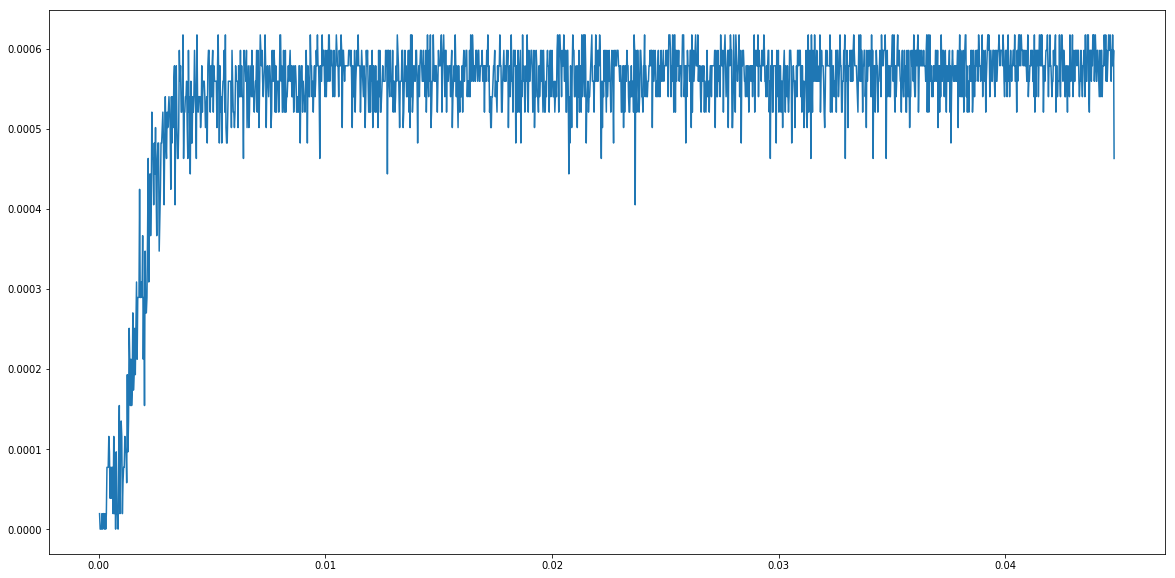

In [21]:
plt.figure(figsize=(20,10))
plt.plot(np.array(lr_find_lr), np.array(accs));

Возьмем диапазон lr, где accuracy возрастает.

#### Тренировка Resnet152

In [22]:
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft = model_ft.to(device)

### Определим параметры

In [23]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            #print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            pass
            #print("\t",name)

Params to learn:


In [24]:
base_lr = 0.0012
max_lr = 0.0022
num_epoch = 4

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9, nesterov = True)
# цикл lr 4 эпохи
step_size = 2 * math.ceil( len(dataloaders_dict['train']) / batch_size )
scheduler = optim.lr_scheduler.CyclicLR(optimizer_ft, base_lr = base_lr, max_lr = max_lr, step_size_up=step_size, mode='exp_range', gamma=0.994, scale_mode='cycle', cycle_momentum=True, base_momentum=0.8, max_momentum=0.9, last_epoch=-1)

In [25]:
val_loss = []
val_acc = []
train_loss = []
train_acc = []
lr_cycle = []
best_acc = .0

In [26]:
for i in range(num_epoch):
  
    # каждый раз будем подавать сети новые аугментированные данные
    image_datasets = {mode: SimpsonsDataset(train_path[mode], data_transforms[mode]) for mode in ['train', 'val']}

    dataloaders_dict = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=False, num_workers=4),
                          'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=4)}

    model, history_val, history_train, time_elapsed, lr_find_lr, best_acc = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, save_best_weights_path, save_last_weights_path, best_acc = best_acc, num_epochs=1, is_inception=(model_name=="inception"))

    val_loss += history_val['loss']
    val_acc += history_val['acc']
    train_loss += history_train['loss']
    train_acc += history_train['acc']
    lr_cycle += lr_find_lr

Epoch 0/0
----------



train Loss: 0.6428 Acc: 0.8559



val Loss: 0.1336 Acc: 0.9677

Training complete in 7m 14s
Best val Acc: 0.967675
Epoch 0/0
----------



train Loss: 0.0941 Acc: 0.9796



val Loss: 0.0673 Acc: 0.9854

Training complete in 7m 10s
Best val Acc: 0.985350
Epoch 0/0
----------



train Loss: 0.0355 Acc: 0.9939



val Loss: 0.0481 Acc: 0.9901

Training complete in 7m 10s
Best val Acc: 0.990127
Epoch 0/0
----------



train Loss: 0.0191 Acc: 0.9969



val Loss: 0.0442 Acc: 0.9905

Training complete in 7m 10s
Best val Acc: 0.990525


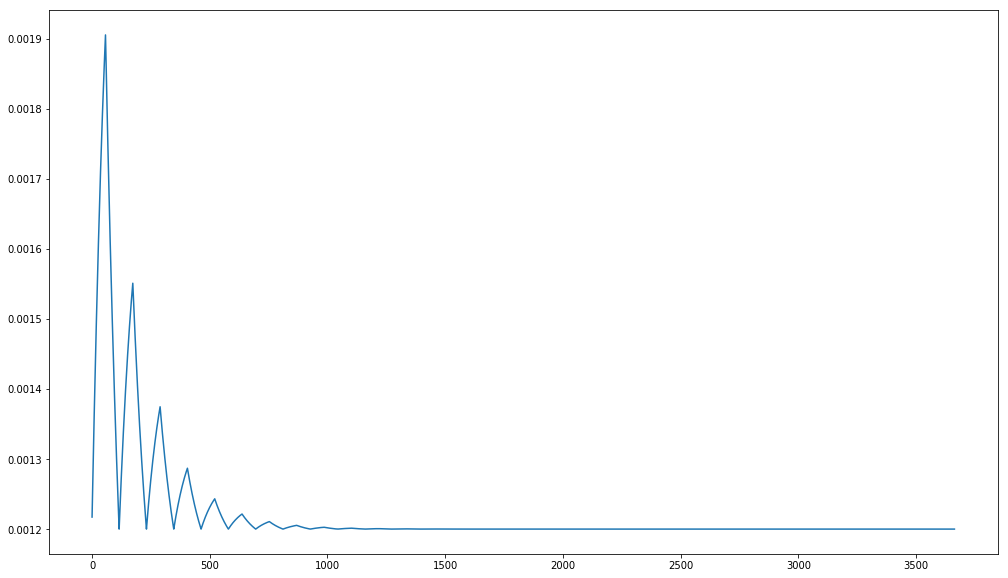

In [27]:
plt.figure(figsize=(17,10))
plt.plot(lr_cycle);

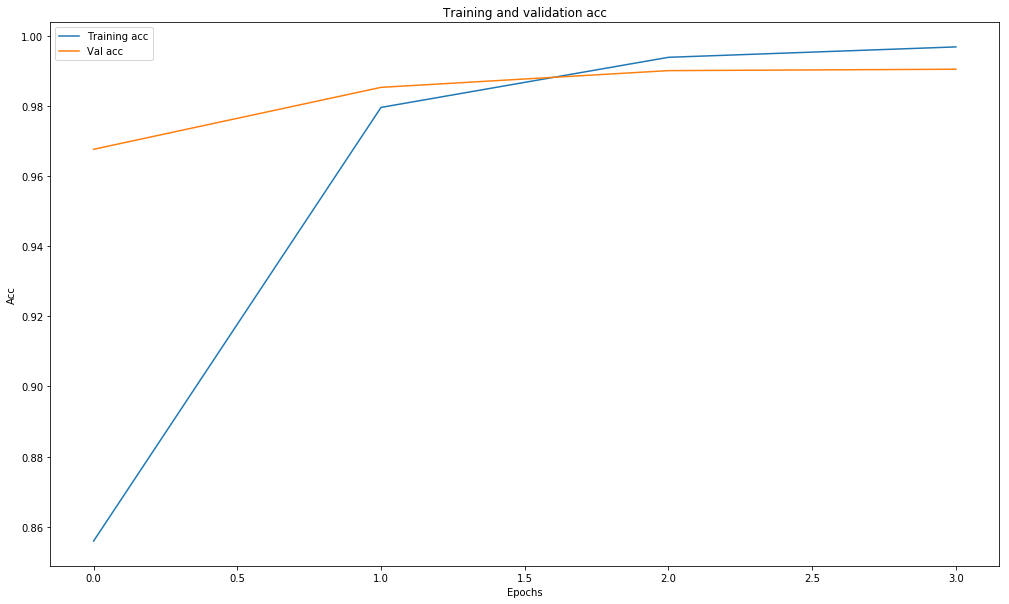

In [28]:
visualization(train_acc, val_acc, is_loss = False)

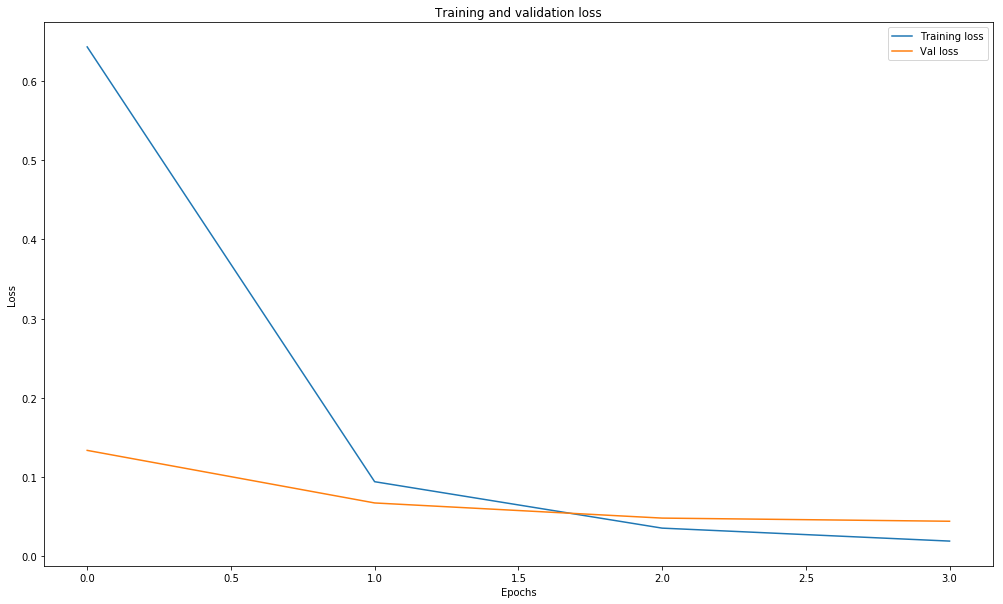

In [29]:
visualization(train_loss, val_loss, is_loss = True)

# Функция предсказания

In [30]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=1).numpy()
    return probs

### Предсказание для одного изображения

In [31]:
def predict_one_sample(model, img_tensor, device=device):
    with torch.no_grad():
        # надо ли в нашем случае?
        img_tensor = img_tensor.to(device)
        model.eval()
        y_hat = model(img_tensor).cpu()
        y_pred = torch.nn.functional.softmax(y_hat, dim=1).numpy()
    return y_pred

# Построим confusion matrix

In [32]:
def confusion_matrix():
    # вытащим настоящие лейблы!
    actual = [image_datasets['val'][i][1] for i in range( len(image_datasets['val']) ) ]
    actual = [val_da['val'][i][1] for i in range( len(image_datasets['val']) ) ]
    
    # вытащим картинки, чтобы их подать в даталоадер, а потом классификатору
    image = [image_datasets['val'][i][0] for i in range( len(image_datasets['val']) ) ]
    
    # подготовим даталоадер
    img_conf_dataloader = torch.utils.data.DataLoader(image, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # вытащим предсказанные лейблы
    probs = predict(model_ft, img_conf_dataloader)
    preds = np.argmax(probs, axis=1)
    
    # создадим таблицу, где в одном столбце будут нстоящие метки, во втором предсказанные
    df = pd.DataFrame({'actual': actual, 'preds': preds})
    
    # margins = False - чтобы не было строки all
    confusion_matrix = pd.crosstab(df['actual'], df['preds'], rownames=['Actual'], colnames=['Predicted'], margins = False)
    
    # загрузим наш инкодер
    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
    
    # получим список классов
    # label_encoder.classes_[i] - можно убедиться, какому классу, какое кодированное число какому классу соответствует
    yticklabels = label_encoder.classes_
    
    plt.subplots(figsize=(20,20))

    sn.heatmap(confusion_matrix, annot=True, fmt="d", linewidths=0.5, cmap="YlGnBu", cbar=False, vmax = 30, yticklabels = yticklabels, xticklabels = yticklabels);

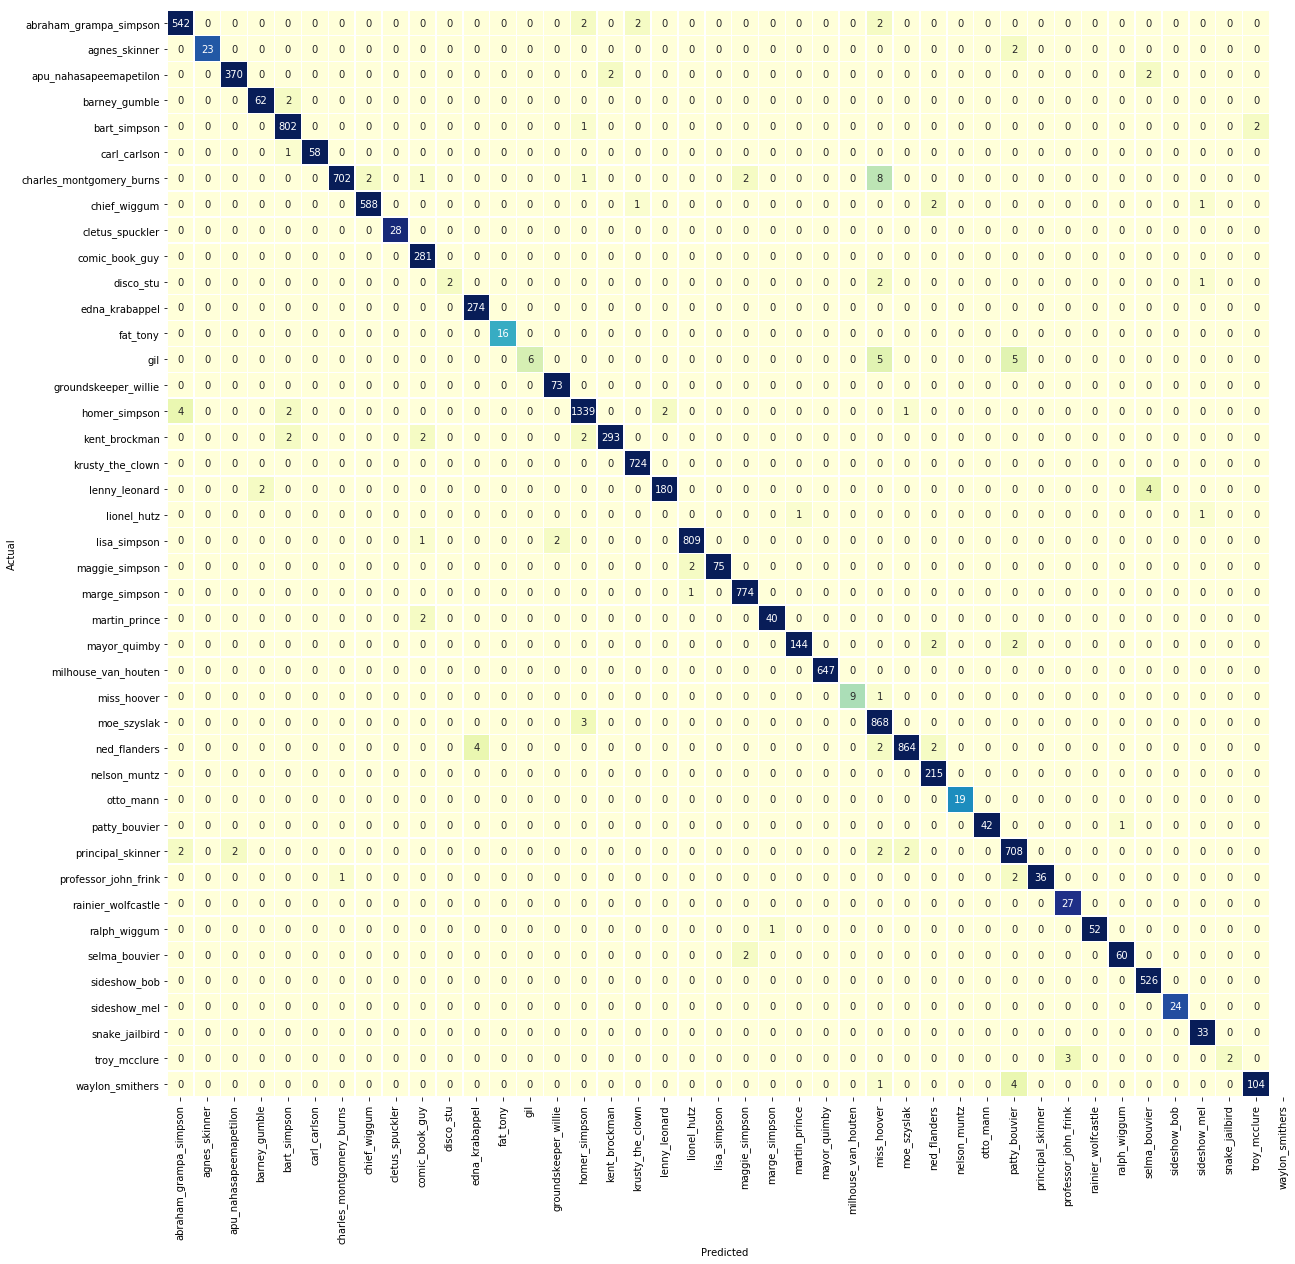

In [33]:
confusion_matrix()

# Визуализируем предсказания модели

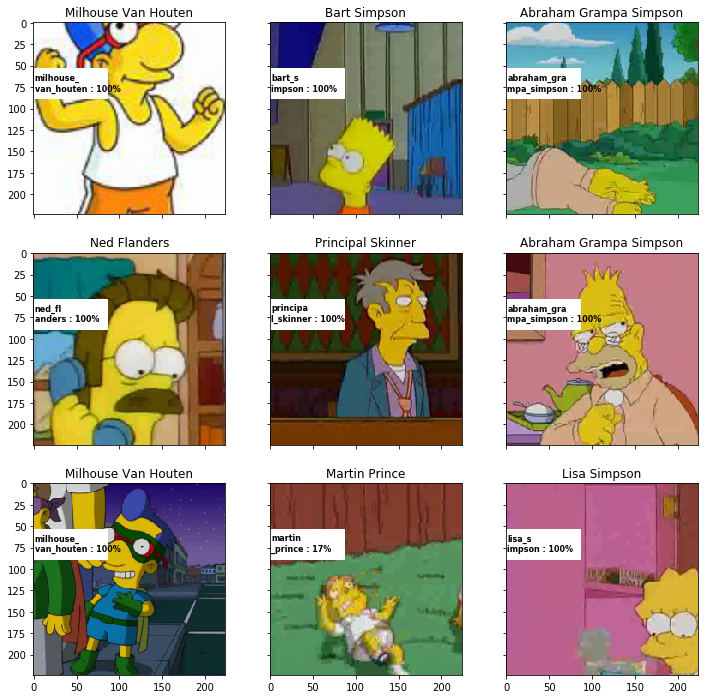

In [34]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), \
                        sharey=True, sharex=True)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = image_datasets['val'][random_characters]
    # inverse_transform это метод LabelEncoder(), мы закодировали цифрами классы, с помощью inverse_transform из чисел вернём название класса
    # получаем имя персонажа с заглавных букв
    img_label = " ".join(map(lambda x: x.capitalize(),\
                image_datasets['val'].label_encoder.inverse_transform([label])[0].split('_')))
    
    imshow(im_val.data.cpu(), \
          title=img_label, plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)

    # добавим область на которой будем выводить вероятность        
    fig_x.add_patch(patches.Rectangle((0, 53), 86, 35, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_ft, im_val.unsqueeze(0))
    # получаем вероятность
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

# Submit на Kaggle

In [35]:
probs = predict(model_ft, dataloader_test)

In [36]:
# загрузим наш инкодер
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [37]:
preds = label_encoder.inverse_transform(np.argmax(probs, axis = 1 ))
test_filenames = [path.name for path in image_datasets_test.files_path]

In [38]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,abraham_grampa_simpson_0.jpg,abraham_grampa_simpson
1,abraham_grampa_simpson_1.jpg,abraham_grampa_simpson
2,abraham_grampa_simpson_10.jpg,abraham_grampa_simpson
3,abraham_grampa_simpson_11.jpg,abraham_grampa_simpson
4,abraham_grampa_simpson_12.jpg,abraham_grampa_simpson


In [39]:
my_submit.to_csv('simspsons.csv', index=False)